Coding project - Tumour segmentation
===============================

For this project it is requested to write a code to automatically segment a tumour in a MRI image and give its area (in cm²).

The code produced is relatively general in the sense that it applies to a number of MRI images including those loaded below. However, it may not work perfectly well on some images as will be detailed below.

In order to segment the tumour, the watershed transform will first be applied to the image as a preprocessing step. As a result, we will get an image made up of different regions. Then, this result will be used as a kind of mask in order to obtain a new image in which for each region calculated during watershed, the pixels will take as value the average RGB value of this region in the original image. Then, a threshold will be applied on this new image in order to keep only the part we are interested in, i.e. the tumour. To calculate the area of the tumour, the regionprops provided in the skimage.measure module will be used.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread,imshow, imsave
from skimage.morphology import disk, watershed
from skimage.color import rgb2gray
import skimage.filters.rank as skr
from skimage.filters import gaussian, rank
from skimage.feature import peak_local_max
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
%matplotlib inline

im = imread('mri_brain.jpg')
#im = imread('another_tumour.png')
#im = imread('BRAIN-TUMOUR3.jpg')

The function get_markers will allow the program to automatically choose the markers that it will place on the image in order to then apply the watershed transform algorithm. To compute the gradient of the image, we convert it to grayscale and apply a median filter to it (to remove some noise) before using the gradient method provided in the skimage.filters.rank module.

In [6]:
def get_markers(im, indices):
    grad = skr.gradient(skr.median(rgb2gray(im),disk(5)), disk(3)) #grad in grayscale
    return peak_local_max(grad.max()-grad, threshold_rel=0.99, min_distance=20, indices=indices), grad

The function get_descr will compute the average RGB value of the region provided in parameter. During the segmentation of the tumour, we are going to call this function on the regions (calculated during the watreshed algorithm) of the original image in order to recover for each region, the average RGB value of its original pixels.

In [7]:
def get_descr(region):
    return [region[:,0].mean(), region[:,1].mean(), region[:,2].mean()]

The tumour_segmentation is the main function of the project which segments the tumour from the rest of the image. It starts by retrieving the markers from which the growing region algorithm will start and assigns an ID to each of them via the label function in the skimage.measure module. It then apply the watershed tranform and stores the result in "ws" which is in image consisting of the regions created during the algorithm. Next, for each region, the average RBG value will be computed on the basis of the original image and a new image "im_descriptors" will be created, containing for each region those calculated average values. Finally, a treshold is applied to this new image in order to create a mask that will set all the pixels, except those of the tumour, to 0. The tumour can therefore be segmented by applying this mask to the original image. To obtain a binary result, the pixels of the tumour are set to 1. Since the threshold is chosen manually, it may not be suitable for all images. However, as the MRI images are generally quite similar and as this threshold value was found to be satisfactory for the 3 images tested here, it was decided that this manual threshold was acceptable for this project and has been kept as such.

Let's now move on to the calculation of the area. We are going to associate a label to each region of the segmented binary image "tum_bin", which in fact amounts to placing a label on the tumour (we consider here that the image contains only one tumour). We will then use the regionprops provided in the skimage.measure module and more precisely its area attribute which returns the area of the region considered in terms of number of pixels. Since a pixel has an area of 0.013225 cm², the total area is obtained by multiplying this constant with the number of pixels.

Tumour area : 45.9172 cm²


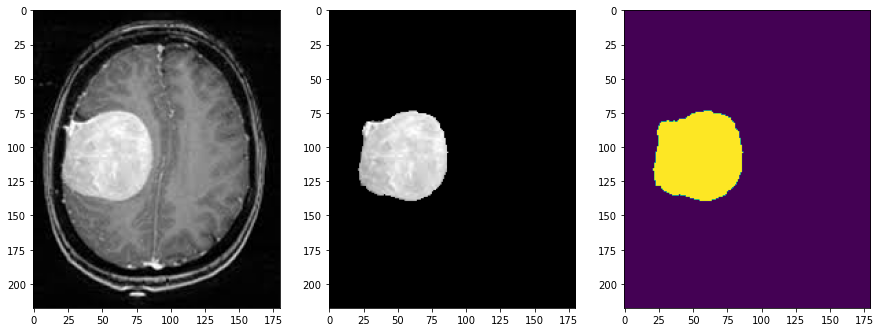

In [8]:
def tumour_segmentation():
    markers, grad = get_markers(im, False)
    markers = label(markers)
    ws = watershed(grad, markers)
    
    descriptors = np.zeros((ws.max()+1,3))
    im_descriptors = np.zeros_like(im)

    for i in range(ws.min(), ws.max()+1):
        descriptors[i] = get_descr(im[ws==i])
        im_descriptors[ws==i] = descriptors[i]
    
    mask = im_descriptors>143
    
    tumour = im*mask
    tum_bin = (tumour[:,:,0]>0).astype(int)
    
    lab = label(tum_bin)
    objects = regionprops(lab)

    tumour_area = objects[0].area*0.013225
    
    return tumour, tum_bin, tumour_area

tumour, tum_bin, tumour_area = tumour_segmentation()
imsave('tumour_segmented.jpg', (tum_bin*255).astype('uint8'))

print('Tumour area :', tumour_area, 'cm²')

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(tumour)
plt.subplot(1,3,3)
plt.imshow(tum_bin)
plt.show()
    